<a href="https://colab.research.google.com/github/sayanbanerjee32/paddy_comp_with_jhoward/blob/main/paddy_comp_initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

!pip install -Uq 'timm>=0.6.2.dev0'
from fastkaggle import *

     |████████████████████████████████| 61 kB 3.3 MB/s 
     |████████████████████████████████| 497 kB 10.0 MB/s 


In [2]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [4]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:09<00:00, 120MB/s]


In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


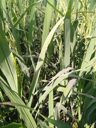

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

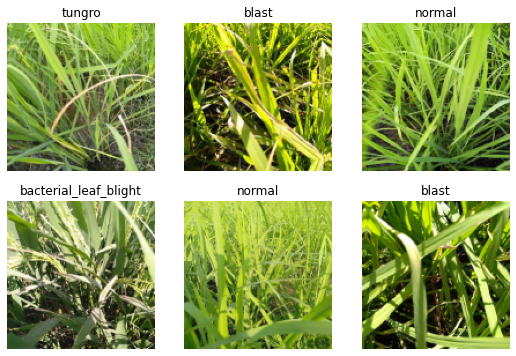

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [11]:
import timm
timm.list_models("convnext*")

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [13]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


SuggestedLRs(valley=0.0003981071640737355, slide=0.0030199517495930195)

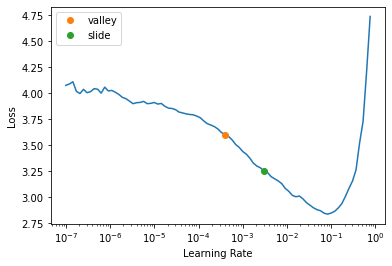

In [14]:
learn.lr_find(suggest_funcs=(valley, slide))

In [16]:
learn.fine_tune(3, 0.003)

epoch,train_loss,valid_loss,error_rate,time
0,0.166211,0.166208,0.047093,01:44


epoch,train_loss,valid_loss,error_rate,time
0,0.141848,0.164431,0.047093,01:45
1,0.124118,0.142687,0.041326,02:10
2,0.113434,0.139529,0.040846,01:53


In [17]:
ss = pd.read_csv(path/'sample_submission.csv')
ss.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [18]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

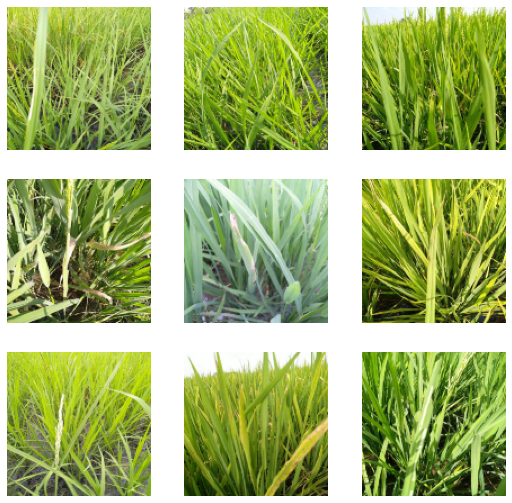

In [23]:
tst_dl.show_batch()

In [19]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [20]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [21]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

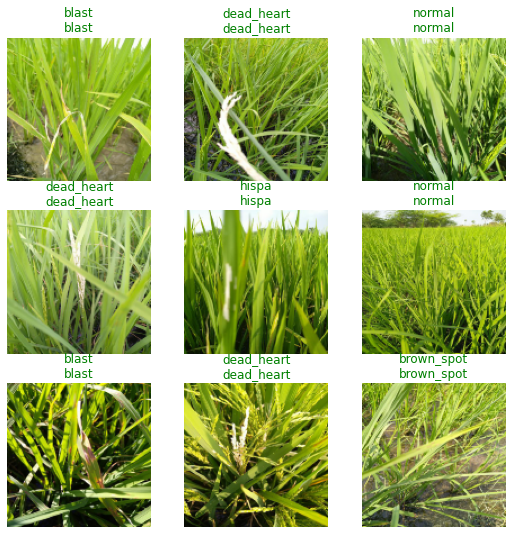

In [25]:
learn.show_results()

In [22]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [26]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial convnext_small 480px', comp)

100%|██████████| 70.3k/70.3k [00:04<00:00, 17.8kB/s]


In [27]:
if not iskaggle:
    push_notebook('saan', 'paddy-initial-model',
                  title='Paddy initial model',
                  file='paddy_comp_initial_model.ipynb',
                  competition=comp, private=True, gpu=True)

ValueError: ignored